## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value']=df_comp.ftse

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [5]:
import warnings
warnings.filterwarnings("ignore")

## The LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

## ARMA(1,1)

In [8]:
model_ret_ar_1_ma_1 = ARMA(df.returns[1:], order=(1,1))
result_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
result_ret_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Sat, 28 Mar 2020   AIC                          15841.000
Time:                        08:53:40   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.returns     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.returns    -0.8141      0.061    -13.406      0.000      -0.933      -0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3074           +0.0000j            1.3074            0.0000
MA.1            1.2284           +0.0000j            1.2284            0.0000
-----------------------------------------------------------------------------
"""

Współczynniki (coef)

Dodatnia wartość ar.L1.return sugeruje dodatnią tendencję między przeszłymi a obecnymi wartościami (zwrtoy poruszają się między dodatnimi a ujemnymi wartościami)

ujemna wartość ma.L1.returns sugeruje, że oddalamy się od wartości przeszłego okresu (t-1). Chcemy zapobiec poruszaniu się naszych celów, zanim uwzględnimy je w obliczeniach

In [9]:
model_ret_ar_1 = ARMA(df.returns[1:], order=(1,0))
model_ret_ma_1 = ARMA(df.returns[1:], order=(0,1))

In [10]:
print('\nARMA vs AR', LLR_test(model_ret_ar_1, model_ret_ar_1_ma_1))
print('\nARMA vs MA', LLR_test(model_ret_ma_1, model_ret_ar_1_ma_1))


ARMA vs AR 0.0

ARMA vs MA 0.0


## Higher-Lag ARMA Models

Użyjemy modelu ARMA(4,3) ponieważ dla AR było 8, a dla MA 6, ale z filmu wynikało, że około połowa wartości jest nieznacząca dlatego użyjemy mniej niż pół czyli ARMA(3,3)

In [15]:
model_ret_ar_3_ma_3 = ARMA(df.returns[1:], order=(3,3))
result_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()

In [16]:
LLR_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3, DF=4)
# DF = 4 bo dla modelu (1,1) były 1+1 = 2, a dla modelu (3,3) 3+3 = 6
# to 6 - 2 = 4

0.0

In [17]:
result_ret_ar_3_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 3)   Log Likelihood               -7893.515
Method:                       css-mle   S.D. of innovations              1.166
Date:                Sat, 28 Mar 2020   AIC                          15803.030
Time:                        09:14:30   BIC                          15855.199
Sample:                    01-10-1994   HQIC                         15821.310
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.395      0.163      -0.008       0.045
ar.L1.returns    -0.1898      0.104     -1.827      0.068      -0.393       0.014
ar.L2.returns    -0.2942      0.087     -3.389      0.001      -0.464      -0.124
ar.L3.returns     0.4459      0.138      3.225      0.001       0.175       0.717
ma.L1.returns     0.1707      0.099      1.726      0.084      -0.023       0.365
ma.L2.returns     0.2277      0.084      2.701      0.007       0.062       0.393
ma.L3.returns    -0.5432      0.127     -4.270      0.000      -0.793      -0.294
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5168           -1.0283j            1.1508           -0.3241
AR.2           -0.5168           +1.0283j            1.1508            0.3241
AR.3            1.6932           -0.0000j            1.6932           -0.0000
MA.1           -0.5286           -0.9835j            1.1166           -0.3285
MA.2           -0.5286           +0.9835j            1.1166            0.3285
MA.3            1.4764           -0.0000j            1.4764           -0.0000
-----------------------------------------------------------------------------
"""

Optymalny model znajduje się pomiędzy ARMA(1,1), a ARMA(3,3)

In [18]:
model_ret_ar_3_ma_2 = ARMA(df.returns[1:], order=(3,2))
result_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
result_ret_ar_3_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 2)   Log Likelihood               -7895.747
Method:                       css-mle   S.D. of innovations              1.166
Date:                Sat, 28 Mar 2020   AIC                          15805.495
Time:                        09:17:33   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.251      0.211      -0.011       0.048
ar.L1.returns    -0.6785      0.087     -7.799      0.000      -0.849      -0.508
ar.L2.returns    -0.5088      0.139     -3.670      0.000      -0.780      -0.237
ar.L3.returns    -0.1141      0.015     -7.655      0.000      -0.143      -0.085
ma.L1.returns     0.6568      0.087      7.536      0.000       0.486       0.828
ma.L2.returns     0.4474      0.141      3.175      0.001       0.171       0.724
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4929           -1.5101j            1.5885           -0.3002
AR.2           -0.4929           +1.5101j            1.5885            0.3002
AR.3           -3.4748           -0.0000j            3.4748           -0.5000
MA.1           -0.7340           -1.3025j            1.4951           -0.3317
MA.2           -0.7340           +1.3025j            1.4951            0.3317
-----------------------------------------------------------------------------
"""

Przy takich wartościach p, trzeba zwracać uwagę na coef

In [19]:
model_ret_ar_2_ma_3 = ARMA(df.returns[1:], order=(2,3))
result_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
result_ret_ar_2_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 3)   Log Likelihood               -7895.587
Method:                       css-mle   S.D. of innovations              1.166
Date:                Sat, 28 Mar 2020   AIC                          15805.174
Time:                        09:19:34   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.276      0.202      -0.010       0.048
ar.L1.returns    -0.5605      0.090     -6.245      0.000      -0.736      -0.385
ar.L2.returns    -0.4187      0.193     -2.172      0.030      -0.797      -0.041
ma.L1.returns     0.5378      0.090      6.000      0.000       0.362       0.714
ma.L2.returns     0.3540      0.195      1.818      0.069      -0.028       0.736
ma.L3.returns    -0.1158      0.016     -7.369      0.000      -0.147      -0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6694           -1.3930j            1.5455           -0.3213
AR.2           -0.6694           +1.3930j            1.5455            0.3213
MA.1           -0.7270           -1.1772j            1.3836           -0.3381
MA.2           -0.7270           +1.1772j            1.3836            0.3381
MA.3            4.5096           -0.0000j            4.5096           -0.0000
-----------------------------------------------------------------------------
"""

Dla ma.L2.returns wartość p jest powyżej 5% dlatego odrzucamy model

In [20]:
LLR_test(model_ret_ar_2_ma_3, model_ret_ar_3_ma_3)

0.042

In [21]:
model_ret_ar_3_ma_1 = ARMA(df.returns[1:], order=(3,1))
result_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
result_ret_ar_3_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 1)   Log Likelihood               -7899.072
Method:                       css-mle   S.D. of innovations              1.167
Date:                Sat, 28 Mar 2020   AIC                          15810.144
Time:                        09:24:53   BIC                          15849.271
Sample:                    01-10-1994   HQIC                         15823.855
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.298      0.194      -0.010       0.047
ar.L1.returns    -0.5077      0.088     -5.769      0.000      -0.680      -0.335
ar.L2.returns    -0.0638      0.016     -4.023      0.000      -0.095      -0.033
ar.L3.returns    -0.1102      0.014     -7.850      0.000      -0.138      -0.083
ma.L1.returns     0.4839      0.088      5.500      0.000       0.311       0.656
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5095           -0.0000j            1.5095           -0.5000
AR.2            0.4653           -2.4076j            2.4521           -0.2196
AR.3            0.4653           +2.4076j            2.4521            0.2196
MA.1           -2.0668           +0.0000j            2.0668            0.5000
-----------------------------------------------------------------------------
"""

In [22]:
LLR_test(model_ret_ar_3_ma_1, model_ret_ar_3_ma_2)

0.01

In [23]:
model_ret_ar_2_ma_2 = ARMA(df.returns[1:], order=(2,2))
result_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
result_ret_ar_2_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 2)   Log Likelihood               -7913.223
Method:                       css-mle   S.D. of innovations              1.170
Date:                Sat, 28 Mar 2020   AIC                          15838.446
Time:                        09:26:47   BIC                          15877.573
Sample:                    01-10-1994   HQIC                         15852.156
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.394      0.163      -0.008       0.045
ar.L1.returns     0.7820      0.238      3.284      0.001       0.315       1.249
ar.L2.returns    -0.1563      0.177     -0.884      0.377      -0.503       0.190
ma.L1.returns    -0.8104      0.239     -3.388      0.001      -1.279      -0.342
ma.L2.returns     0.1177      0.187      0.628      0.530      -0.250       0.485
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5018           -0.3736j            2.5296           -0.0236
AR.2            2.5018           +0.3736j            2.5296            0.0236
MA.1            1.6107           +0.0000j            1.6107            0.0000
MA.2            5.2744           +0.0000j            5.2744            0.0000
-----------------------------------------------------------------------------
"""

ar.L2.returns i ma.L2.returns mają dużą wartość p dlatego tego modelu nie używamy

In [24]:
model_ret_ar_1_ma_3 = ARMA(df.returns[1:], order=(1,3))
result_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
result_ret_ar_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 3)   Log Likelihood               -7896.838
Method:                       css-mle   S.D. of innovations              1.167
Date:                Sat, 28 Mar 2020   AIC                          15805.676
Time:                        09:29:28   BIC                          15844.803
Sample:                    01-10-1994   HQIC                         15819.386
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.332      0.183      -0.009       0.047
ar.L1.returns    -0.4699      0.096     -4.901      0.000      -0.658      -0.282
ma.L1.returns     0.4474      0.095      4.691      0.000       0.260       0.634
ma.L2.returns    -0.0637      0.015     -4.113      0.000      -0.094      -0.033
ma.L3.returns    -0.1182      0.014     -8.200      0.000      -0.146      -0.090
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1282           +0.0000j            2.1282            0.5000
MA.1           -1.4882           -1.1206j            1.8629           -0.3973
MA.2           -1.4882           +1.1206j            1.8629            0.3973
MA.3            2.4376           -0.0000j            2.4376           -0.0000
-----------------------------------------------------------------------------
"""

In [27]:
print("\n ARMA(3,2): LL = ", result_ret_ar_3_ma_2.llf, "AIC = ", result_ret_ar_3_ma_2.aic)
print("\n ARMA(1,3): LL = ", result_ret_ar_1_ma_3.llf, "AIC = ", result_ret_ar_1_ma_3.aic)


 ARMA(3,2): LL =  -7895.747458514602 AIC =  15805.494917029204

 ARMA(1,3): LL =  -7896.837893752821 AIC =  15805.675787505643


Lepszym modelem jest ARMA(3,2) ponieważ wszystkie współczynniki są znaczące i wyprzedza swoje mniej skomplikowane alternatywy

## Residuals for Returns

In [28]:
df['res_ret_ar_3_ma_2'] = result_ret_ar_3_ma_2.resid[1:]

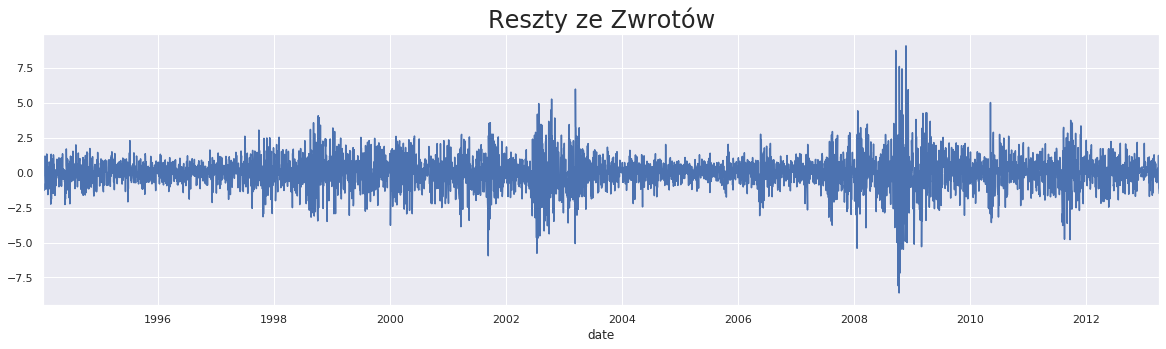

In [29]:
df.res_ret_ar_3_ma_2.plot(figsize=(20,5))
plt.title('Reszty ze Zwrotów', size=24);

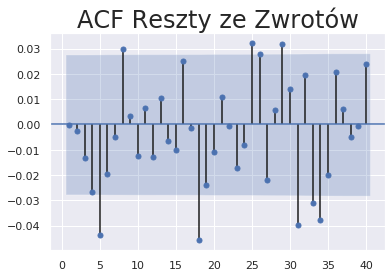

In [30]:
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], zero=False, lags=40)
plt.title('ACF Reszty ze Zwrotów', size=24);

## Reevaluating Model Selection

In [31]:
model_ret_ar_5_ma_5 = ARMA(df.returns[1:], order=(5,5))
result_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()
result_ret_ar_5_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 5)   Log Likelihood               -7882.160
Method:                       css-mle   S.D. of innovations              1.163
Date:                Sat, 28 Mar 2020   AIC                          15788.321
Time:                        09:58:53   BIC                          15866.575
Sample:                    01-10-1994   HQIC                         15815.742
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.402      0.161      -0.008       0.045
ar.L1.returns    -0.0684      0.140     -0.490      0.624      -0.342       0.205
ar.L2.returns    -0.6722      0.146     -4.603      0.000      -0.958      -0.386
ar.L3.returns    -0.1152      0.141     -0.817      0.414      -0.392       0.161
ar.L4.returns     0.1779      0.129      1.381      0.167      -0.075       0.430
ar.L5.returns     0.1215      0.107      1.132      0.258      -0.089       0.332
ma.L1.returns     0.0443      0.138      0.322      0.748      -0.226       0.314
ma.L2.returns     0.6223      0.144      4.321      0.000       0.340       0.905
ma.L3.returns     0.0107      0.136      0.079      0.937      -0.256       0.277
ma.L4.returns    -0.1753      0.122     -1.436      0.151      -0.415       0.064
ma.L5.returns    -0.2240      0.104     -2.148      0.032      -0.428      -0.020
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0870           -1.0364j            1.0401           -0.2367
AR.2            0.0870           +1.0364j            1.0401            0.2367
AR.3            1.7715           -0.0000j            1.7715           -0.0000
AR.4           -1.7050           -1.1784j            2.0726           -0.4038
AR.5           -1.7050           +1.1784j            2.0726            0.4038
MA.1            0.1033           -1.0434j            1.0485           -0.2343
MA.2            0.1033           +1.0434j            1.0485            0.2343
MA.3            1.4855           -0.0000j            1.4855           -0.0000
MA.4           -1.2373           -1.0965j            1.6532           -0.3846
MA.5           -1.2373           +1.0965j            1.6532            0.3846
-----------------------------------------------------------------------------
"""

i w AR i MA są współczynnik nie istotne, dlatego trzeba wybrać 5 albo dla AR albo dla MA (na filmie sprawdzili wszystkie i wyszło, że jest tylko ARMA(1,5) albo ARMA(5,1)

In [32]:
model_ret_ar_1_ma_5 = ARMA(df.returns[1:], order=(1,5))
result_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
result_ret_ar_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 5)   Log Likelihood               -7890.973
Method:                       css-mle   S.D. of innovations              1.165
Date:                Sat, 28 Mar 2020   AIC                          15797.947
Time:                        10:01:18   BIC                          15850.116
Sample:                    01-10-1994   HQIC                         15816.228
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.419      0.156      -0.007       0.045
ar.L1.returns     0.3285      0.152      2.159      0.031       0.030       0.627
ma.L1.returns    -0.3534      0.152     -2.332      0.020      -0.650      -0.056
ma.L2.returns    -0.0404      0.015     -2.624      0.009      -0.071      -0.010
ma.L3.returns    -0.0679      0.017     -4.022      0.000      -0.101      -0.035
ma.L4.returns     0.0742      0.020      3.771      0.000       0.036       0.113
ma.L5.returns    -0.0683      0.015     -4.660      0.000      -0.097      -0.040
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.0443           +0.0000j            3.0443            0.0000
MA.1           -1.1897           -1.1548j            1.6580           -0.3774
MA.2           -1.1897           +1.1548j            1.6580            0.3774
MA.3            1.5041           -0.0000j            1.5041           -0.0000
MA.4            0.9809           -1.6057j            1.8815           -0.1627
MA.5            0.9809           +1.6057j            1.8815            0.1627
-----------------------------------------------------------------------------
"""

In [33]:
model_ret_ar_5_ma_1 = ARMA(df.returns[1:], order=(5,1))
result_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
result_ret_ar_5_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 1)   Log Likelihood               -7889.311
Method:                       css-mle   S.D. of innovations              1.165
Date:                Sat, 28 Mar 2020   AIC                          15794.623
Time:                        10:01:55   BIC                          15846.792
Sample:                    01-10-1994   HQIC                         15812.903
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.407      0.159      -0.007       0.045
ar.L1.returns     0.3440      0.131      2.624      0.009       0.087       0.601
ar.L2.returns    -0.0458      0.015     -3.005      0.003      -0.076      -0.016
ar.L3.returns    -0.0652      0.016     -4.010      0.000      -0.097      -0.033
ar.L4.returns     0.0741      0.018      4.068      0.000       0.038       0.110
ar.L5.returns    -0.0813      0.014     -5.688      0.000      -0.109      -0.053
ma.L1.returns    -0.3673      0.131     -2.801      0.005      -0.624      -0.110
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6158           -0.0000j            1.6158           -0.5000
AR.2            1.3793           -0.8613j            1.6261           -0.0888
AR.3            1.3793           +0.8613j            1.6261            0.0888
AR.4           -0.1156           -1.6929j            1.6968           -0.2608
AR.5           -0.1156           +1.6929j            1.6968            0.2608
MA.1            2.7223           +0.0000j            2.7223            0.0000
-----------------------------------------------------------------------------
"""

In [34]:
print("\n ARMA(5,1): LL = ", result_ret_ar_5_ma_1.llf, "AIC = ", result_ret_ar_5_ma_1.aic)
print("\n ARMA(1,5): LL = ", result_ret_ar_1_ma_5.llf, "AIC = ", result_ret_ar_1_ma_5.aic)


 ARMA(5,1): LL =  -7889.3112829458405 AIC =  15794.622565891681

 ARMA(1,5): LL =  -7890.97346020948 AIC =  15797.94692041896


Należy wybrać ARMA(5,1) ponieważ LL  jest większe, a AIC mniejsze

In [35]:
# teraz porównujemy z poprzednim najlepszym modelem (3,2)
print("\n ARMA(3,2): LL = ", result_ret_ar_3_ma_2.llf, "AIC = ", result_ret_ar_3_ma_2.aic)


 ARMA(3,2): LL =  -7895.747458514602 AIC =  15805.494917029204


Należy wybrać ARMA(5,1) ponieważ LL  jest większe, a AIC mniejsze

## Residuals for the New Model

In [36]:
df['res_ret_ar_5_ma_1'] = result_ret_ar_5_ma_1.resid

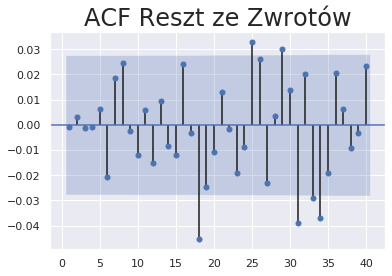

In [37]:
sgt.plot_acf(df.res_ret_ar_5_ma_1[1:], zero=False, lags=40)
plt.title('ACF Reszt ze Zwrotów', size=24);

## ARMA Models for Prices

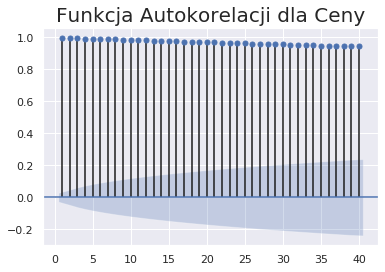

In [39]:
sgt.plot_acf(df.market_value, unbiased=True, zero=False, lags=40)
plt.title('Funkcja Autokorelacji dla Ceny', size=20);

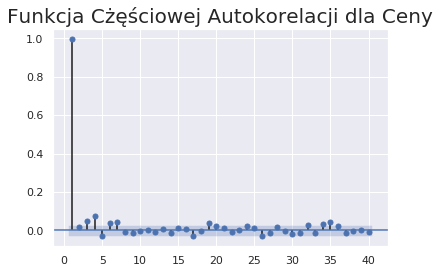

In [38]:
sgt.plot_pacf(df.market_value, alpha=0.05, zero=False, lags=40, method=('ols'))
plt.title('Funkcja Cżęściowej Autokorelacji dla Ceny', size=20);

In [40]:
model_ar_1_ma_1 = ARMA(df.market_value, order=(1,1))
result_ar_1_ma_1 = model_ar_1_ma_1.fit()
result_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 1)   Log Likelihood              -27621.784
Method:                       css-mle   S.D. of innovations             59.248
Date:                Sat, 28 Mar 2020   AIC                          55251.568
Time:                        10:14:10   BIC                          55277.654
Sample:                    01-07-1994   HQIC                         55260.709
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5036.1372    496.535     10.143      0.000    4062.946    6009.329
ar.L1.market_value     0.9985      0.001   1325.248      0.000       0.997       1.000
ma.L1.market_value    -0.0190      0.015     -1.274      0.203      -0.048       0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
MA.1           52.5080           +0.0000j           52.5080            0.0000
-----------------------------------------------------------------------------
"""

In [41]:
df['res_ar_1_ma_1'] = result_ar_1_ma_1.resid

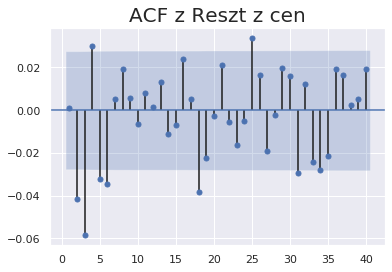

In [42]:
sgt.plot_acf(df.res_ar_1_ma_1, zero=False, lags=40)
plt.title('ACF z Reszt z cen', size=20);

In [43]:
# model_ar_6_ma_6 = ARMA(df.market_value, order=(6,6))
# result_ar_6_ma_6 = model_ar_6_ma_6.fit()
# result_ar_6_ma_6.summary()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [45]:
model_ar_6_ma_6 = ARMA(df.market_value, order=(6,6))
result_ar_6_ma_6 = model_ar_6_ma_6.fit(start_ar_lags = 11)
result_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 6)   Log Likelihood              -27587.932
Method:                       css-mle   S.D. of innovations             58.849
Date:                Sat, 28 Mar 2020   AIC                          55203.864
Time:                        10:18:30   BIC                          55295.164
Sample:                    01-07-1994   HQIC                         55235.856
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6496    568.407      8.954      0.000    3975.593    6203.706
ar.L1.market_value     1.9273      0.032     60.022      0.000       1.864       1.990
ar.L2.market_value    -1.7357      0.040    -43.437      0.000      -1.814      -1.657
ar.L3.market_value     1.2679      0.034     36.884      0.000       1.200       1.335
ar.L4.market_value    -0.2376      0.157     -1.515      0.130      -0.545       0.070
ar.L5.market_value    -0.4058      0.164     -2.474      0.013      -0.727      -0.084
ar.L6.market_value     0.1836      0.049      3.765      0.000       0.088       0.279
ma.L1.market_value    -0.9483      0.035    -27.072      0.000      -1.017      -0.880
ma.L2.market_value     0.7800      0.032     24.216      0.000       0.717       0.843
ma.L3.market_value    -0.5086      0.031    -16.347      0.000      -0.570      -0.448
ma.L4.market_value    -0.1561      0.158     -0.991      0.322      -0.465       0.153
ma.L5.market_value     0.0948      0.057      1.675      0.094      -0.016       0.206
ma.L6.market_value     0.0670      0.024      2.816      0.005       0.020       0.114
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0857           -1.0502j            1.0537           -0.2370
AR.2            0.0857           +1.0502j            1.0537            0.2370
AR.3           -2.0268           -0.0000j            2.0268           -0.5000
AR.4            1.0011           -0.0000j            1.0011           -0.0000
AR.5            1.5324           -0.2646j            1.5550           -0.0272
AR.6            1.5324           +0.2646j            1.5550            0.0272
MA.1            0.1028           -1.0612j            1.0661           -0.2346
MA.2            0.1028           +1.0612j            1.0661            0.2346
MA.3            1.3631           -0.2787j            1.3913           -0.0321
MA.4            1.3631           +0.2787j            1.3913            0.0321
MA.5           -2.1733           -1.4347j            2.6042           -0.4071
MA.6           -2.1733           +1.4347j            2.6042            0.4071
-----------------------------------------------------------------------------
"""

In [47]:
model_ar_5_ma_6 = ARMA(df.market_value, order=(5,6))
result_ar_5_ma_6 = model_ar_5_ma_6.fit(start_ar_lags = 7)
result_ar_5_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 6)   Log Likelihood              -27587.863
Method:                       css-mle   S.D. of innovations             58.849
Date:                Sat, 28 Mar 2020   AIC                          55201.726
Time:                        10:19:51   BIC                          55286.504
Sample:                    01-07-1994   HQIC                         55231.433
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6476    580.925      8.761      0.000    3951.055    6228.240
ar.L1.market_value     1.3584      0.177      7.656      0.000       1.011       1.706
ar.L2.market_value    -1.1288      0.237     -4.765      0.000      -1.593      -0.665
ar.L3.market_value     0.9146      0.228      4.005      0.000       0.467       1.362
ar.L4.market_value     0.0160      0.203      0.079      0.937      -0.383       0.415
ar.L5.market_value    -0.1613      0.119     -1.353      0.176      -0.395       0.072
ma.L1.market_value    -0.3795      0.178     -2.133      0.033      -0.728      -0.031
ma.L2.market_value     0.7293      0.125      5.835      0.000       0.484       0.974
ma.L3.market_value    -0.2197      0.153     -1.438      0.151      -0.519       0.080
ma.L4.market_value    -0.1388      0.114     -1.217      0.224      -0.362       0.085
ma.L5.market_value    -0.0879      0.017     -5.325      0.000      -0.120      -0.056
ma.L6.market_value     0.0265      0.024      1.128      0.259      -0.020       0.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0917           -1.0418j            1.0458           -0.2360
AR.2            0.0917           +1.0418j            1.0458            0.2360
AR.3            1.0010           -0.0000j            1.0010           -0.0000
AR.4            1.8979           -0.0000j            1.8979           -0.0000
AR.5           -2.9831           -0.0000j            2.9831           -0.5000
MA.1            0.1071           -1.0487j            1.0542           -0.2338
MA.2            0.1071           +1.0487j            1.0542            0.2338
MA.3           -1.5355           -1.5155j            2.1575           -0.3760
MA.4           -1.5355           +1.5155j            2.1575            0.3760
MA.5            1.5918           -0.0000j            1.5918           -0.0000
MA.6            4.5793           -0.0000j            4.5793           -0.0000
-----------------------------------------------------------------------------
"""

In [48]:
model_ar_6_ma_1 = ARMA(df.market_value, order=(6,1))
result_ar_6_ma_1 = model_ar_6_ma_1.fit(start_ar_lags = 7)
result_ar_6_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 1)   Log Likelihood              -27594.195
Method:                       css-mle   S.D. of innovations             58.923
Date:                Sat, 28 Mar 2020   AIC                          55206.389
Time:                        10:20:29   BIC                          55265.082
Sample:                    01-07-1994   HQIC                         55226.956
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6422    586.530      8.678      0.000    3940.064    6239.220
ar.L1.market_value     1.3921      0.058     23.931      0.000       1.278       1.506
ar.L2.market_value    -0.4369      0.059     -7.401      0.000      -0.553      -0.321
ar.L3.market_value    -0.0101      0.025     -0.409      0.683      -0.059       0.038
ar.L4.market_value     0.1126      0.025      4.527      0.000       0.064       0.161
ar.L5.market_value    -0.1158      0.025     -4.717      0.000      -0.164      -0.068
ar.L6.market_value     0.0573      0.014      4.067      0.000       0.030       0.085
ma.L1.market_value    -0.4126      0.060     -6.925      0.000      -0.529      -0.296
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           -0.0000j            1.0010           -0.0000
AR.2           -1.7608           -0.0000j            1.7608           -0.5000
AR.3           -0.0803           -1.8407j            1.8425           -0.2569
AR.4           -0.0803           +1.8407j            1.8425            0.2569
AR.5            1.4694           -0.8691j            1.7072           -0.0850
AR.6            1.4694           +0.8691j            1.7072            0.0850
MA.1            2.4234           +0.0000j            2.4234            0.0000
-----------------------------------------------------------------------------
"""

In [49]:
print("\n ARMA(5,6): LL = ", result_ar_5_ma_6.llf, "AIC = ", result_ar_5_ma_6.aic)
print("\n ARMA(6,1): LL = ", result_ar_6_ma_1.llf, "AIC = ", result_ar_6_ma_1.aic)


 ARMA(5,6): LL =  -27587.862948629063 AIC =  55201.725897258126

 ARMA(6,1): LL =  -27594.19457102027 AIC =  55206.38914204054


Wybieramy ARMA(5,6)

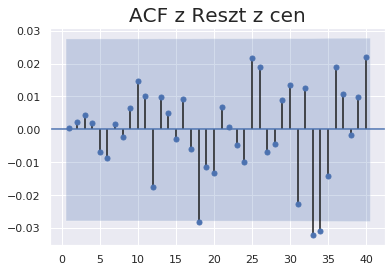

In [50]:
df['res_ar_5_ma_6'] = result_ar_5_ma_6.resid
sgt.plot_acf(df.res_ar_5_ma_6, zero=False, lags=40)
plt.title('ACF z Reszt z cen', size=20);

## ARMA for Returns vs ARMA for Prices

In [52]:
print("\n ARMA(5,6): LL = ", result_ar_5_ma_6.llf, "AIC = ", result_ar_5_ma_6.aic)
print("\n ARMA(5,1): LL = ", result_ret_ar_5_ma_1.llf, "AIC = ", result_ret_ar_5_ma_1.aic)


 ARMA(5,6): LL =  -27587.862948629063 AIC =  55201.725897258126

 ARMA(5,1): LL =  -7889.3112829458405 AIC =  15794.622565891681
